In [1]:
import time

from pyAgrum.lib.bn2graph import BN2dot
import numpy as np
import pandas as pd

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as expl

import matplotlib.pyplot as plt

## Building the model

We build a simple graph for the example

In [2]:
template=gum.fastBN("X1->X2->Y;X3->Z->Y;X0->Z;X1->Z;X2->R[5];Z->R;X1->Y")
data_path = "res/shap/Data_6var_direct_indirect.csv" 

#gum.generateCSV(template,data_path,1000)

learner = gum.BNLearner(data_path,template)
bn = learner.learnParameters(template.dag())
bn

(gum::BayesNet<double>@0x7ffa1a3afe00) BN{nodes: 7, arcs: 9, domainSize: 320, dim: 62}

# 1-independence list w.r.t. the class Y
Given a model, it may be to investigate the conditional independences of the class Y created by this very model. 

{('Y', 'R', ('X2', 'Z')): 0.8684231094674686,
 ('Y', 'X0', ('X1', 'Z')): 0.5816487109659612,
 ('Y', 'X3', ('X1', 'Z')): 0.8774081450472304}

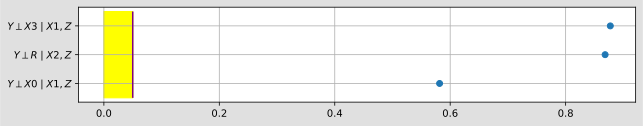

In [3]:
expl.independenceListForPairs(bn,data_path,target="Y")

# 2-ShapValues

The ShapValue class implements the calculation of Shap values in Bayesian networks. It is necessary to specify a target and to provide a Bayesian network whose parameters are known and will be used later in the different calculation methods.

ShapValues use a `pandas.DataFrame` with this base as its database.

In [4]:
train = pd.read_csv(data_path).sample(frac=1.)

In [5]:
gumshap = expl.ShapValues(bn, 'Y')

## Compute Conditionnal in Bayesian Network

A dataset must be provided so that the Bayesian network can learn its parameters and then predict.

The method `conditional` computes the conditonal shap values using the Bayesian Networks. It returns 2 graphs and a dictionary. The first one shows the distribution of the shap values for each of the variables, the second one classifies the variables by their importance.

Run Time : 11.703253984451294 sec


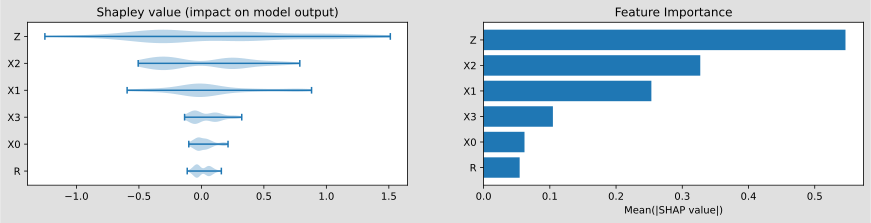

In [6]:
t_start = time.time()
resultat = gumshap.conditional(train, plot=True,plot_importance=True,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

Run Time : 11.123866081237793 sec


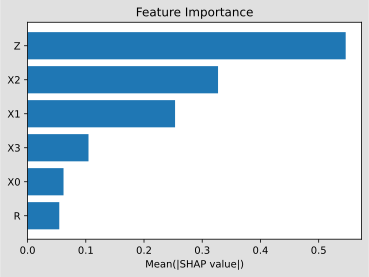

In [7]:
t_start = time.time()
resultat = gumshap.conditional(train, plot=False,plot_importance=True,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

Run Time : 10.489974021911621 sec


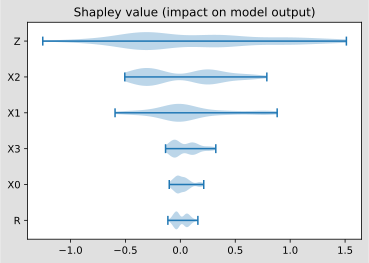

In [8]:
t_start = time.time()
resultat = gumshap.conditional(train, plot=True,plot_importance=False,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

The result is returned as a dictionary, the keys are the names of the features and the associated value is the absolute value of the average of the calculated shap.

In [9]:
t_start = time.time()
resultat = gumshap.conditional(train, plot=False,plot_importance=False,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')
resultat

Run Time : 10.29119324684143 sec


{'X1': 0.2533375405370652,
 'Z': 0.5464180054433385,
 'X3': 0.10465402104047898,
 'X0': 0.061767122000001715,
 'X2': 0.3271606443752007,
 'R': 0.054456334441524}

## Causal Shap Values

This method is similar to the previous one, except the formula of computation. It computes the causal shap value as described in the paper of Heskes *Causal Shapley Values: Exploiting Causal Knowledge
to Explain Individual Predictions of Complex Models* .

Run Time : 12.258903980255127 sec


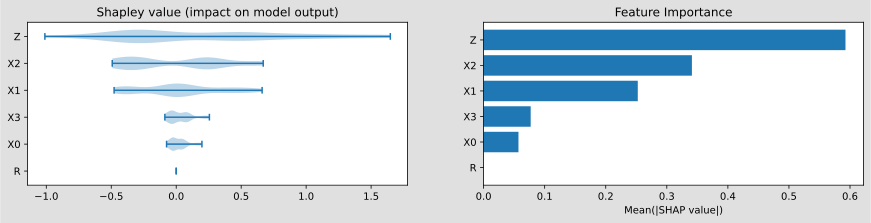

In [10]:
t_start = time.time()
causal = gumshap.causal(train, plot=True, plot_importance=True, percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

As you can see, since $R$ is not among the 'causes' of Y, its causal importance is null.

## Marginal Shap Values

Similarly, one can also compute marginal Shap Value.

Run Time : 51.08573389053345 sec
{'X1': 0.41926342910436293, 'Z': 0.6709279379059467, 'X3': 0.0, 'X0': 0.0, 'X2': 0.41637078555384804, 'R': 0.0}


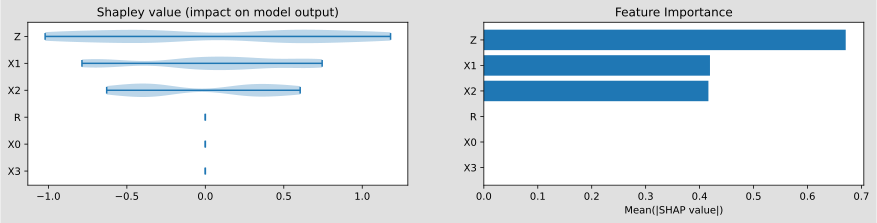

In [11]:
t_start = time.time()
marginal = gumshap.marginal(train, sample_size=10, plot=True,plot_importance=True,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')
print(marginal)

As you can see, since $R$, $X0$ and $X3$ are no in the Markov Blanket of $Y$, their marginal importances are null.

## Visualizing shapvalues directly on a BN

This method returns a coloured graph that makes it easier to understand which variable is important and where it is located in the graph.

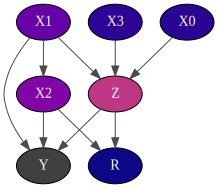

In [12]:
import pyAgrum.lib.notebook as gnb

g = gumshap.showShapValues(causal)
gnb.showGraph(g)